# Examples

## The model book

This example only requires the `foxes` package:

In [1]:
import foxes

The `model book` contains all models that are selectable during a `foxes` run. They are organized according to their model type and stored under a `str` type key, i.e., the model name. The default constructor of the `ModelBook` class provides a number of default models, and the complete list can be printed using the `print_toc` function:

In [2]:
mbook = foxes.models.ModelBook()
mbook.print_toc()

farm_controllers
----------------
basic_ctrl: basic_ctrl (BasicFarmController)

farm_models
-----------
farm_kTI: Turbine2FarmModel(kTI(kTI=None, ti=TI))
farm_kTI_02: Turbine2FarmModel(kTI_02 (kTI)(kTI=0.2, ti=TI))
farm_kTI_04: Turbine2FarmModel(kTI_04 (kTI)(kTI=0.4, ti=TI))
farm_kTI_amb: Turbine2FarmModel(kTI_amb (kTI)(kTI=None, ti=AMB_TI))
farm_kTI_amb_02: Turbine2FarmModel(kTI_amb_02 (kTI)(kTI=0.2, ti=AMB_TI))
farm_kTI_amb_04: Turbine2FarmModel(kTI_amb_04 (kTI)(kTI=0.4, ti=AMB_TI))

partial_wakes
-------------
auto: auto (Mapped)
axiwake10: axiwake10 (PartialAxiwake)(n=10)
axiwake2: axiwake2 (PartialAxiwake)(n=2)
axiwake20: axiwake20 (PartialAxiwake)(n=20)
axiwake3: axiwake3 (PartialAxiwake)(n=3)
axiwake4: axiwake4 (PartialAxiwake)(n=4)
axiwake5: axiwake5 (PartialAxiwake)(n=5)
axiwake6: axiwake6 (PartialAxiwake)(n=6)
axiwake7: axiwake7 (PartialAxiwake)(n=7)
axiwake8: axiwake8 (PartialAxiwake)(n=8)
axiwake9: axiwake9 (PartialAxiwake)(n=9)
distsliced: distsliced (PartialDistSlicedWake

You can simply add a model by storing the model object under the new model name, for example:

In [3]:
mbook.wake_models["Jensen_linear_k004"] = \
    foxes.models.wake_models.top_hat.JensenWake(k=0.04, superposition="linear")

In [4]:
mbook.print_toc(subset="wake_models", search="Jensen")

wake_models
-----------
Jensen_linear: Jensen_linear (JensenWake)(k=None, sp=linear)
Jensen_linear_amb: Jensen_linear_amb (JensenWake)(k=None, sp=linear_amb)
Jensen_linear_amb_k007: Jensen_linear_amb_k007 (JensenWake)(k=0.07, sp=linear_amb)
Jensen_linear_k004: JensenWake(k=0.04, sp=linear)
Jensen_linear_k007: Jensen_linear_k007 (JensenWake)(k=0.07, sp=linear)



## Single row of turbines

We start with the imports for this example:

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

The `foxes` setup consists of creating: 

1. The so-called `model book`, which contains all selectable models
2. Ambient wind conditions, called `states` in `foxes` terminology
3. The `wind farm`, collecting all turbine information
4. The `algorithm` with its parameters and model choices

Here is a simple example for a single row of turbines along the x axis and a uniform wind speed with wind direction 270°:

In [6]:
# Create model book and add turbine type model:
# The csv file will be searched in the file system,
# and if not found, taken from static library
mbook = foxes.ModelBook()
mbook.turbine_types["NREL5"] = foxes.models.turbine_types.PCtFile("NREL-5MW-D126-H90.csv")

# create ambient wind conditions, a single uniform state:
states = foxes.input.states.SingleStateStates(ws=9., wd=270., ti=0.06, rho=1.225)

# create wind farm, a single row of turbines:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=[0., 0.], 
    xy_step=[800., 0.], 
    n_turbines=5,
    turbine_models=["NREL5"],
    verbosity=0
)

# setup the calculation algorithm:
algo = foxes.algorithms.Downwind(mbook, farm, states, verbosity=0,
                                 wake_models=["Jensen_linear_k007"])

Now we can ask the `algorithm` object to run the calculation. This returns a `xarray.Dataset` object with results for each state and turbine:

In [7]:
farm_results = algo.calc_farm()
print("\nFarm results:\n", farm_results)


Farm results:
 <xarray.Dataset>
Dimensions:    (state: 1, turbine: 5)
Dimensions without coordinates: state, turbine
Data variables: (12/24)
    weight     (state, turbine) float64 1.0 1.0 1.0 1.0 1.0
    X          (state, turbine) float64 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
    Y          (state, turbine) float64 0.0 0.0 0.0 0.0 0.0
    H          (state, turbine) float64 90.0 90.0 90.0 90.0 90.0
    D          (state, turbine) float64 126.0 126.0 126.0 126.0 126.0
    P          (state, turbine) float64 2.519e+03 1.557e+03 ... 1.107e+03
    ...         ...
    AMB_REWS3  (state, turbine) float64 9.0 9.0 9.0 9.0 9.0
    AMB_TI     (state, turbine) float64 0.06 0.06 0.06 0.06 0.06
    AMB_RHO    (state, turbine) float64 1.225 1.225 1.225 1.225 1.225
    order      (state, turbine) float64 0.0 1.0 2.0 3.0 4.0
    AMB_CT     (state, turbine) float64 0.79 0.79 0.79 0.79 0.79
    AMB_P      (state, turbine) float64 2.519e+03 2.519e+03 ... 2.519e+03


For a convenient summary printout we can easily convert the results into a `pandas.DataFrame`:

In [8]:
fr = farm_results.to_dataframe()
print(fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.TI, FV.AMB_P, FV.P, FV.CT]])

                  WD  AMB_REWS      REWS    TI   AMB_P            P        CT
state turbine                                                                
0     0        270.0       9.0  9.000000  0.06  2518.6  2518.600000  0.790000
      1        270.0       9.0  7.633459  0.06  2518.6  1557.076947  0.803665
      2        270.0       9.0  7.176627  0.06  2518.6  1290.332498  0.808234
      3        270.0       9.0  6.955794  0.06  2518.6  1167.325199  0.812210
      4        270.0       9.0  6.821354  0.06  2518.6  1106.880886  0.818932


Once the farm calculation results are ready, we can evaluate the wake corrected flow and all points of interest. For example, we can evaluate the wind speed along the centre line:


Point results:
 <xarray.Dataset>
Dimensions:  (state: 1, point: 8000)
Dimensions without coordinates: state, point
Data variables:
    WS       (state, point) float64 9.0 9.0 9.0 9.0 ... 8.916 8.916 8.916 8.916
    WD       (state, point) float64 270.0 270.0 270.0 ... 270.0 270.0 270.0
    TI       (state, point) float64 0.06 0.06 0.06 0.06 ... 0.06 0.06 0.06 0.06
    RHO      (state, point) float64 1.225 1.225 1.225 ... 1.225 1.225 1.225
    AMB_WS   (state, point) float64 9.0 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0 9.0
    AMB_WD   (state, point) float64 270.0 270.0 270.0 ... 270.0 270.0 270.0
    AMB_TI   (state, point) float64 0.06 0.06 0.06 0.06 ... 0.06 0.06 0.06 0.06
    AMB_RHO  (state, point) float64 1.225 1.225 1.225 ... 1.225 1.225 1.225


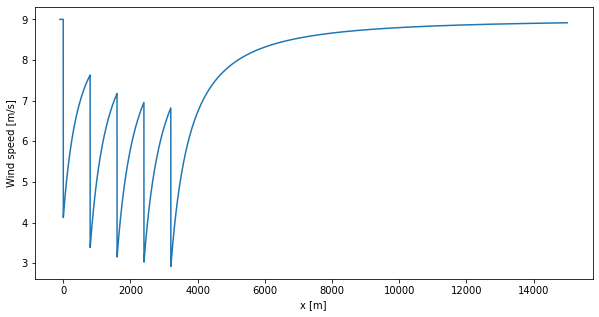

In [9]:
# infer hub height from turbine type:
H = mbook.turbine_types["NREL5"].H

# create points of interest, shape (n_states, n_points, 3):
n_points = 8000
points   = np.zeros((1, n_points, 3))
points[:, :, 0] = np.linspace(-100., 15000., n_points)[None, :]
points[:, :, 2] = H

# calculate point results:
point_results = algo.calc_points(farm_results, points)
print("\nPoint results:\n", point_results)

# create figure:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(points[0, :, 0], point_results[FV.WS][0, :])
ax.set_xlabel("x [m]")
ax.set_ylabel("Wind speed [m/s]")
plt.show()

The `foxes.output` package provides a collection of standard outputs. For example, we can visualize the flow field in a horizontal slice at hub height:

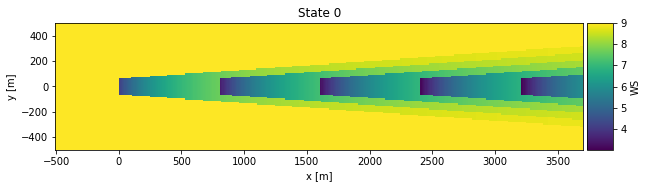

In [10]:
o   = foxes.output.FlowPlots2D(algo, farm_results)
g   = o.gen_states_fig_horizontal("WS", resolution=10, figsize=(10,5), verbosity=0)
fig = next(g) # creates the figure for the next state, here there is only state 0
plt.show()

## Timeseries data

In this example we calculate the data of a wind farm with 67 turbines in a time series containing 8000 uniform inflow states.

The required imports are:

In [11]:
import dask
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

import foxes

First, we create the `model book`, adding the turbine type model (see examples above):

In [12]:
mbook = foxes.ModelBook()
mbook.turbine_types["NREL5"] = foxes.models.turbine_types.PCtFile("NREL-5MW-D126-H90.csv")

Next, we create the `states`. The `data_source` can be any csv-type file (or `pandas` readable equivalent), or a `pandas.DataFrame` object. If it is a file path, then it will first be searched in the file system, and if not found, in the static data. If it is also not found there, an error showing the available static data file names is displayed.

In this example the static data file `timeseries_8000.csv.gz` will be used, with content
```
Time,ws,wd,ti
2017-01-01 00:00:00,15.62,244.06,0.0504
2017-01-01 00:30:00,15.99,243.03,0.0514
2017-01-01 01:00:00,16.31,243.01,0.0522
2017-01-01 01:30:00,16.33,241.26,0.0523
...
```
Notice the column names, and how they appear in the `foxes.Timeseries` constructor:

In [13]:
states = foxes.input.states.Timeseries(
    data_source="timeseries_8000.csv.gz",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.TI: "ti"},
    fixed_vars={FV.RHO: 1.225}
)

Likewise, we create the example wind farm with 67 turbines from static data. The file `test_farm_67.csv` has the following structure:
```
index,label,x,y
0,T0,101872.70,1004753.57
1,T1,103659.97,1002993.29
2,T2,100780.09,1000779.97
3,T3,100290.42,1004330.88
...
```
For more options, check the API section `foxes.input.farm_layout`. 

We consider two turbine models in this example: the wind turbine type `NREL5` from above, and the model `kTI_02` from the `model book`. This model adds the variable `k` for each state and turbine, calculated as `k = kTI * TI`, with constant `kTI = 0.2`. The parameter `k` will later be used by the wake model.

In [14]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_from_file(
    farm,
    "test_farm_67.csv",
    turbine_models=["kTI_02", "NREL5"],
    verbosity=0
)

Next, we create the `algorithm`, with further model selections. In particular, two wake models are invoked, the model `Bastankhah_linear` for wind speed deficits and the model `CrespoHernandez_quadratic` for turbulence intensity:

In [15]:
algo = foxes.algorithms.Downwind(
            mbook,
            farm,
            states=states,
            rotor_model="centre",
            turbine_order="order_wd",
            wake_models=["Bastankhah_linear", "CrespoHernandez_quadratic"],
            wake_frame="rotor_wd",
            partial_wakes_model="auto",
            chunks={FV.STATE: 1000},
            verbosity=0
        )

Also notice the `chunks` parameter, specifying that always 1000 states should be considered in vectorized form during calculations. The progress can be visualized using `dask`'s `ProgressBar`:

In [16]:
with ProgressBar():
    farm_results = algo.calc_farm()

fr = farm_results.to_dataframe()
print("\n", fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.AMB_P, FV.P]])

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 13.7s
[########################################] | 100% Completed |  0.1s

                                  WD  AMB_REWS       REWS    AMB_P            P
state               turbine                                                   
2017-01-01 00:00:00 0        244.06     15.62  15.595077  5000.00  5000.000000
                    1        244.06     15.62  14.018359  5000.00  5000.000000
                    2        244.06     15.62  15.067607  5000.00  5000.000000
                    3        244.06     15.62  15.522240  5000.00  5000.000000
                    4        244.06     15.62  14.555445  5000.00  5000.000000
...                             ...       ...        ...      ...          ...
2017-06-16 15:30:00 62       299.19     11.70   9.195743  4868.75  2700.601871
                    63       299.19     11.70  11.422432  4868.75  4747.313968
    